In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.linear_model import LinearRegression as LR, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA

In [2]:
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target)

In [3]:
"""
MedInc：该街区住户的收入中位数
HouseAge：该街区房屋使用年代的中位数
AveRooms：该街区平均的房间数目
AveBedrms：该街区平均的卧室数目
Population：街区人口
AveOccup：平均入住率
Latitude：街区的纬度
Longitude：街区的经度

target: 该街区房价中位数
"""
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [4]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.3,random_state=42)

## 1. 多元线性回归模型
在机器学习中，线性回归的参数可以通过两种主要方法计算得到：最小二乘法和梯度下降。
1. 最小二乘法：这是一种解析方法，通过求解正规方程（Normal Equation）直接得到参数的最优解。   
2. 梯度下降：这是一种迭代优化方法，通过不断更新参数以逐步减小损失函数（例如均方误差）的值。梯度下降在大数据集和复杂模型中更为常用，因为它可以处理最小二乘法难以处理的问题。

最小二乘法优缺点：

1) 一次计算即可得到最优解(全局最优解)，但极小值为全局最小值；

2) 当特征数量 n 大于10000时，因计算矩阵逆的时间复杂度O(n^3)会很大；

3) 只适用于线性模型，不适用于逻辑回归等其他模型。

In [19]:
lr = LR().fit(Xtrain, Ytrain)
Ypred = lr.predict(Xtest)
Ypred

array([[0.72604907],
       [1.76743383],
       [2.71092161],
       ...,
       [2.07465531],
       [1.57371395],
       [1.82744133]])


<b>属性 coef_ 和 intercept_</b>    
y = w1*x1 + w2*x2 + ... + wn*xn + b   
coef_ 就是特征系数 w1,w2,...wn   
intercept_ 就是截距 b


In [23]:
print(lr.coef_)
print(lr.intercept_)

[[ 4.45822565e-01  9.68186799e-03 -1.22095112e-01  7.78599557e-01
  -7.75740400e-07 -3.37002667e-03 -4.18536747e-01 -4.33687976e-01]]
[-37.05624133]


In [22]:
lr.intercept_

array([-37.05624133])

## 2. 线性回归评估指标

MSE   
R<sup>2</sup>   
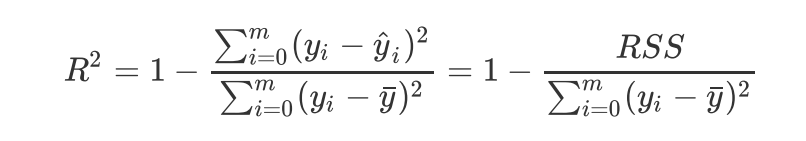  
在R<sup>2</sup> 中，分子是真实值和预测值之差的
差值，也就是我们的模型没有捕获到的信息总量，分母是真实标签所带的信息量，所以其衡量的是1 - 我们的模型没
有捕获到的信息量占真实标签中所带的信息量的比例，所以， 越接近1越好

In [24]:
MSE(Ytest,Ypred)

0.5305677824766752

In [25]:
print(lr.score(Xtest, Ytest)) # 使用的R方评估
r2_score(Ytest,Ypred) 


0.5957702326061664


0.5957702326061664

可以看出MSE不是很大，但R2也不是很高（一般0.8以上才算比较好）。说明一部分数据很好拟合，但没有很好的找出规律信息（比如数据分布规律、单调性）   

另外，当R2为负数时，表明拟合效果糟糕到不能用了。一方面检查数据处理是否出问题了，数据处理步骤正确则表明当前严重欠拟合！

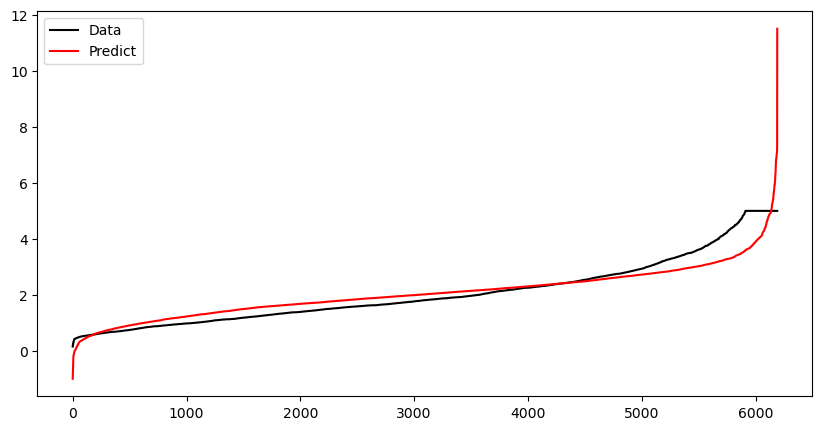

In [41]:
# 绘制预测房价的变化规律
plt.figure(figsize=(10,5))
y_test_list = Ytest.values.flatten()
y_pred_list = Ypred.flatten()
plt.plot(range(len(y_test_list)),sorted(y_test_list),c="black",label= "Data")
plt.plot(range(len(y_pred_list)),sorted(y_pred_list),c="red",label = "Predict")
plt.legend()

## 3. 多重共线性：岭回归与Lasso

多重共线性：高度相关的特征列向量之间，会形成“共线”，特征列向量之间的这种高度相关性称为多重共线性。   


多重共线性是指在多元线性回归分析中，自变量之间存在较高的相关性。这会对回归分析产生以下影响：  
1. 参数估计不稳定：多重共线性会导致回归系数的估计值变得不稳定，即使数据中的小变化也可能导致系数估计值发生较大的变化。这使得模型难以解释和应用。
2. 系数解释困难：由于自变量之间的高相关性，很难确定哪个自变量对因变量的影响更大。这使得模型的解释变得复杂，不易理解。
3. 降低模型准确性：多重共线性可能导致模型的预测准确性降低，因为高度相关的自变量可能会相互抵消彼此的影响。 
4. 在线性回归模型中，多重共线性使得参数不能通过最小二乘法求得，只能使用梯度下降。


解决办法：   
+ 特征选取，相关性分析，筛选除去高度相关的特征
+ PCA降维
+ 岭回归或LASSO

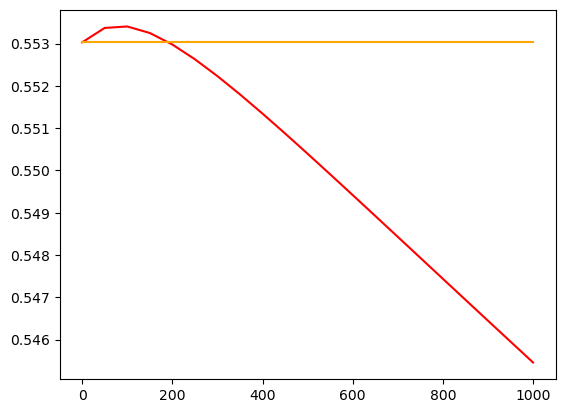

In [46]:
alpharange = np.arange(0,1001,50)
ridge_scores, lr_scores = [], []

lr = LinearRegression()
lr_socre = cross_val_score(lr,X,y,cv=5,scoring = "r2").mean()
for alpha in alpharange:
    ridge = Ridge(alpha=alpha)
    ridge_score = cross_val_score(ridge,X,y,cv=5,scoring = "r2").mean()
    ridge_scores.append(ridge_score)
    lr_scores.append(lr_socre)


plt.plot(alpharange, ridge_scores, color="red",label="Ridge")
plt.plot(alpharange, lr_scores, color="orange",label="LR")

当特征系数w之间差别很大，分散，使用Ridge可缩小系数值的差距。
然而当alpha过大会导致特征系数集中，体现不出特征权重。    
房价数据集中，正则化带来的准确率提升不大，解释：本来特征系数w之前的差距不大，

<b>方差膨胀因子</b>   
其中$R^2_i$是将第i个变量$x_i$作为因变量，其他k-1个变量作为自变量进行线性回归获得的$R^2$
，且令 $ VIF_i=\frac{1}{1−R^2_i}$   

$R^2_i$ < 1, 当$R^2_i$越接近1，说明$x_i$可其他向量（变量）线性表出。

$VIF_i$ > 5 (或 $VIF_i$ > 10) 说明$x_i$严重多重共线

In [49]:
# 方差膨胀因子
from statsmodels.stats.outliers_influence import variance_inflation_factor

#计算第2个变量的(第二列)的方差膨胀因子，注意python的计数是从0开始的，所以第二个参数应该是1
variance_inflation_factor(Xtrain, 1)   

7.12328507578429

In [58]:
VIF_list = [variance_inflation_factor(Xtrain, i) for i in range(Xtrain.shape[1])]
for col, VIF_i in zip(Xtrain.columns.to_list(), VIF_list):
    print(f"{col}: {VIF_i}")

MedInc: 11.613264651525688
HouseAge: 7.12328507578429
AveRooms: 46.48592287427087
AveBedrms: 48.05606548520666
Population: 2.91088338109827
AveOccup: 1.0735574916298196
Latitude: 560.3954732824286
Longitude: 640.0979730973129


In [89]:
# X_drop = X.drop(columns=['MedInc', 'HouseAge',  'AveRooms', 'AveBedrms', 'Latitude', 'Longitude'])
pca = PCA(n_components=3)
x_drop = pca.fit_transform(X)
print(pca.explained_variance_ratio_)  # 无论是手动删除相关特征，还是采用PCA，最终的MSE和R2并没有下降
X_drop

[9.99789327e-01 1.13281110e-04 8.32834638e-05]


,Population
0,322.0
1,2401.0
2,496.0
3,558.0
4,565.0
...,...
20635,845.0
20636,356.0
20637,1007.0
20638,741.0


In [78]:
Xtrain_drop, Xtest_drop, Ytrain_drop, Ytest_drop = train_test_split(X,y,test_size=0.3,random_state=42)

In [79]:
lr = LR().fit(Xtrain_drop, Ytrain_drop)
Ypred_drop = lr.predict(Xtest)
Ypred_drop

array([[0.72604907],
       [1.76743383],
       [2.71092161],
       ...,
       [2.07465531],
       [1.57371395],
       [1.82744133]])

In [80]:
print(MSE(Ytest_drop, Ypred_drop))
print(r2_score(Ytest_drop, Ypred_drop))

0.5305677824766752
0.5957702326061664


##### 使用Ridge回归

选取最佳正则化参数

In [95]:
Ridge_ = RidgeCV(alphas=np.arange(1,1001,100)
                #,scoring="neg_mean_squared_error" # 默认R2
                 ,store_cv_values=True
                 #,cv=5  # 默认采用留一法（计算成本高）
               ).fit(X, y)
Ridge_.score(X,y)

0.606025176733844

In [101]:
#结构是 (n_samples, n_alphas)
print(Ridge_.cv_values_.shape) 
#进行平均后可以查看每个正则化系数取值下的交叉验证结果
Ridge_.cv_values_.mean(axis=0)


(20640, 1, 10)


array([[0.52823795, 0.52787439, 0.52807763, 0.52855759, 0.52917958,
        0.52987689, 0.53061486, 0.53137481, 0.53214638, 0.53292369]])

In [92]:
Ridge_.alpha_ #最佳alpha

101

In [104]:
Ridge_ = RidgeCV(alphas=np.arange(50,151,1)
                #,scoring="neg_mean_squared_error" # 默认R2
                 ,store_cv_values=True
                 #,cv=5  # 默认采用留一法（计算成本高）
               ).fit(X, y)
Ridge_.alpha_ #最佳alpha

103

使用Ridge Regression建模

In [106]:
ridge = Ridge(alpha=103)
ridge.fit(Xtrain, Ytrain)
Ypred_ridge = ridge.predict(Xtest)
print(MSE(Ytest, Ypred_ridge))
print(r2_score(Ytest, Ypred_ridge))  

# 使用Ridge Regression后，准确率有小幅度所提升

0.5265171022273988
0.5988563708697987


##### 使用Lasso回归  
不同于Ridge Regression，Lasso对alpha十分敏感，并且取值范围空间很小

In [19]:
Ytrain

,0
7061,1.93800
14689,1.69700
17323,2.59800
10056,1.36100
15750,5.00001
...,...
11284,2.29200
11964,0.97800
5390,2.22100
860,2.83500


选择最佳正则化参数   
自定义alpha范围，logspace(start, end, num, base) 生成num个数，x属于(start,end),y = $base^x$

In [31]:
alpha_range = np.logspace(-10,-2,200, base=10)
alpha_range

array([1.00000000e-10, 1.09698580e-10, 1.20337784e-10, 1.32008840e-10,
       1.44811823e-10, 1.58856513e-10, 1.74263339e-10, 1.91164408e-10,
       2.09704640e-10, 2.30043012e-10, 2.52353917e-10, 2.76828663e-10,
       3.03677112e-10, 3.33129479e-10, 3.65438307e-10, 4.00880633e-10,
       4.39760361e-10, 4.82410870e-10, 5.29197874e-10, 5.80522552e-10,
       6.36824994e-10, 6.98587975e-10, 7.66341087e-10, 8.40665289e-10,
       9.22197882e-10, 1.01163798e-09, 1.10975250e-09, 1.21738273e-09,
       1.33545156e-09, 1.46497140e-09, 1.60705282e-09, 1.76291412e-09,
       1.93389175e-09, 2.12145178e-09, 2.32720248e-09, 2.55290807e-09,
       2.80050389e-09, 3.07211300e-09, 3.37006433e-09, 3.69691271e-09,
       4.05546074e-09, 4.44878283e-09, 4.88025158e-09, 5.35356668e-09,
       5.87278661e-09, 6.44236351e-09, 7.06718127e-09, 7.75259749e-09,
       8.50448934e-09, 9.32930403e-09, 1.02341140e-08, 1.12266777e-08,
       1.23155060e-08, 1.35099352e-08, 1.48202071e-08, 1.62575567e-08,
      

In [33]:
lasso = LassoCV(alphas=alpha_range).fit(Xtrain,Ytrain.values.ravel())
print(lasso.alphas_.shape)
print(lasso.alpha_)

(200,)
0.0001289890261253308


建模

In [36]:
lasso = Lasso(alpha=0.0001289890261253308)
lasso.fit(Xtrain, Ytrain)
Ypred_lasso = lasso.predict(Xtest)
print(MSE(Ytest, Ypred_lasso))
print(r2_score(Ytest, Ypred_lasso))  #  ridge > lasso效果 > linear

0.5304018649259226
0.5958966421153045


In [26]:
3.20903069e+01

32.0903069

##### 比较岭回归带来的特征系数w的变化

In [9]:
lr = LR().fit(Xtrain, Ytrain)
w_lr = lr.coef_[0]
w_lr

array([ 4.45822565e-01,  9.68186799e-03, -1.22095112e-01,  7.78599557e-01,
       -7.75740400e-07, -3.37002667e-03, -4.18536747e-01, -4.33687976e-01])

In [10]:
ridge = Ridge(alpha=103).fit(Xtrain, Ytrain)
w_ridge = ridge.coef_[0]
w_ridge

array([ 4.31012897e-01,  9.88493230e-03, -9.37825509e-02,  6.20089200e-01,
       -2.11771073e-07, -3.33026604e-03, -4.15874593e-01, -4.28868789e-01])

In [38]:
lasso = Lasso(alpha=0.0001289890261253308).fit(Xtrain, Ytrain)
w_lasso = lasso.coef_
w_lasso

array([ 4.45320536e-01,  9.68964861e-03, -1.21129632e-01,  7.73275648e-01,
       -7.50692434e-07, -3.36795040e-03, -4.18373270e-01, -4.33445907e-01])

0 : MedInc
1 : HouseAge
2 : AveRooms
3 : AveBedrms
4 : Population
5 : AveOccup
6 : Latitude
7 : Longitude


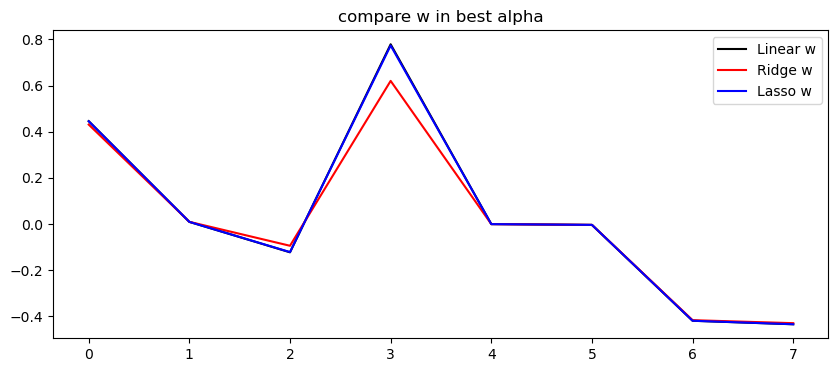

In [42]:
plt.figure(figsize=(10,4))
ax = plt.subplot()
ax.plot(range(len(w_lr)), w_lr, c='black')
ax.plot(range(len(w_ridge)), w_ridge, c='red')
ax.plot(range(len(w_lasso)), w_lasso, c='blue')
ax.legend(['Linear w', 'Ridge w', 'Lasso w'])
ax.set_title("compare w in best alpha")
for i,col in enumerate(Xtrain.columns):
    print(f"{i} : {col}")

In [40]:
Xtrain.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,3.876892,28.575374,5.438125,1.098033,1427.927326,3.119236,35.650669,-119.584102
std,1.904908,12.613634,2.453569,0.447498,1140.225190,12.373636,2.135742,2.002930
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.692308,32.550000,-124.350000
25%,2.567225,18.000000,4.448928,1.006783,791.000000,2.430380,33.940000,-121.800000
50%,3.539100,29.000000,5.232422,1.049492,1168.000000,2.817147,34.270000,-118.510000
75%,4.758075,37.000000,6.060692,1.100328,1727.000000,3.279135,37.720000,-118.010000
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.310000


分析： Ridge压缩了w，而Lasso几乎没有对w产生影响（和linear的w保持一致）

Text(0.5, 1.0, 'compare compression for w')

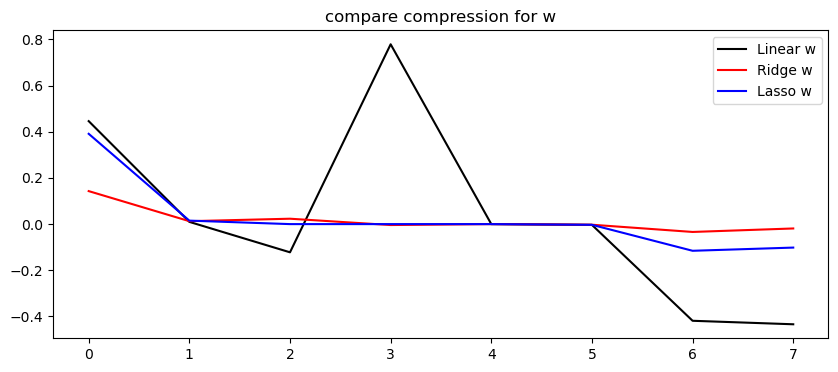

In [51]:
lr = LR().fit(Xtrain, Ytrain)
w_lr = lr.coef_[0]
ridge = Ridge(alpha=100000).fit(Xtrain, Ytrain)
w_ridge = ridge.coef_[0]
lasso = Lasso(alpha=0.1).fit(Xtrain, Ytrain)
w_lasso = lasso.coef_

plt.figure(figsize=(10,4))
ax = plt.subplot()
ax.plot(range(len(w_lr)), w_lr, c='black')
ax.plot(range(len(w_ridge)), w_ridge, c='red')
ax.plot(range(len(w_lasso)), w_lasso, c='blue')
ax.legend(['Linear w', 'Ridge w', 'Lasso w'])
ax.set_title("compare compression for w")

In [52]:
pd.DataFrame([w_lr, w_ridge, w_lasso])

,0,1,2,3,4,5,6,7
0,0.445823,0.009682,-0.122095,0.778600,-7.757404e-07,-0.003370,-0.418537,-0.433688
1,0.142870,0.012697,0.023356,-0.004019,1.784373e-05,-0.002670,-0.033947,-0.018867
2,0.390945,0.015060,-0.000000,0.000000,1.838984e-05,-0.003065,-0.115484,-0.101649


比较随机变量“2”和“3”， Lasso直接将这两个变量压缩至0，而Ridge始终无法将这两个压缩至0

##### 总结
1. 回归模型加入正则化后（线性回归/逻辑回归加入Ridge/Lasso）,适中的alpha参数可以防止过拟合，但当alpha过大时将使模型欠拟合
2. Ridge能有效消除多重共线性，最终可以采用最小二乘法一步到位求解极值；Lasso多数情况不一定能消除多重共线性，将采用坐标下降法
3. Ridge不会把w压缩至0（可以很小）；Lasso可以将w压缩至0，从而进行了特征选择。

## 4.分箱 和 多项式回归 （处理非线性数据）

In [59]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import KBinsDiscretizer

##### 分箱的基本原理

In [108]:
# 分箱的基本原理
from sklearn.preprocessing import KBinsDiscretizer
enc_1 = KBinsDiscretizer(n_bins=3,encode="ordinal") #分成3个箱子（类别）
X_simple = np.array([4,3,9,8,5,2,1,7,6]).reshape(-1,1) 
y_simple = np.array([4,3,9,8,5,2,1,7,6])
print(X_simple)
X_simple_binned = enc.fit_transform(X_simple) #将数据从小到大排成三段，标记为0,1,2三个类别
X_simple_binned

[[4]
 [3]
 [9]
 [8]
 [5]
 [2]
 [1]
 [7]
 [6]]


array([[1.],
       [0.],
       [2.],
       [2.],
       [1.],
       [0.],
       [0.],
       [2.],
       [1.]])

In [109]:
# 采用哑变量处理分类
enc_2 = KBinsDiscretizer(n_bins=3,encode="onehot")
X_matrix = enc_2.fit_transform(X_simple)
X_simple_pd = pd.DataFrame(X_matrix.toarray())
X_simple_pd

,0,1,2
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,0.0,0.0,1.0
8,0.0,1.0,0.0


In [121]:
# 分箱后 对线性模型建模
y_simple_pred = LR().fit(X_simple,y_simple).predict(X_simple)
y_simple_pred2 = LR().fit(X_simple_binned,y_simple).predict(X_simple_binned)

Text(0.5, 1.0, 'use KBinsDiscretizer')

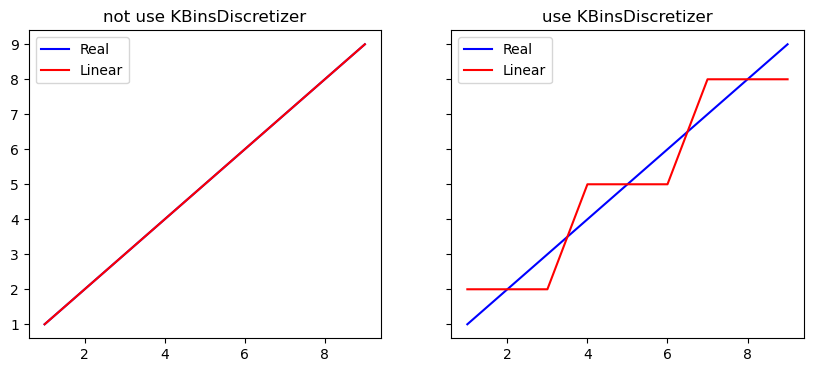

In [125]:
fig, (ax1, ax2) = plt.subplots(ncols=2
                               , sharey=True #让两张图共享y轴上的刻度
                               , figsize=(10, 4))
x_range = sorted(X_simple)
ax1.plot(x_range, x_range, c='b')
ax1.plot(x_range, sorted(y_simple_pred), c='r')
ax1.legend(['Real', 'Linear'])
ax1.set_title('not use KBinsDiscretizer')

x_range = sorted(X_simple)
ax2.plot(x_range, x_range, c='b')
ax2.plot(x_range, sorted(y_simple_pred2), c='r')
ax2.legend(['Real', 'Linear'])
ax2.set_title('use KBinsDiscretizer')

In [ ]:
可以看出，被分箱后的数据在预测时，将x=1,x=2,x=3预测为y=2。可见一个预测的大致思路是：   
训练时，对样本X分类，针对这个分类数据输出“均值”。测试时，将测试样本分类，对应到哪个类便输出对应“均值”

In [118]:
# 分箱后 对决策树建模
y_simple_pred = DecisionTreeRegressor().fit(X_simple,y_simple).predict(X_simple)
y_simple_pred2 = DecisionTreeRegressor().fit(X_simple_binned,y_simple).predict(X_simple_binned)

Text(0.5, 1.0, 'use KBinsDiscretizer')

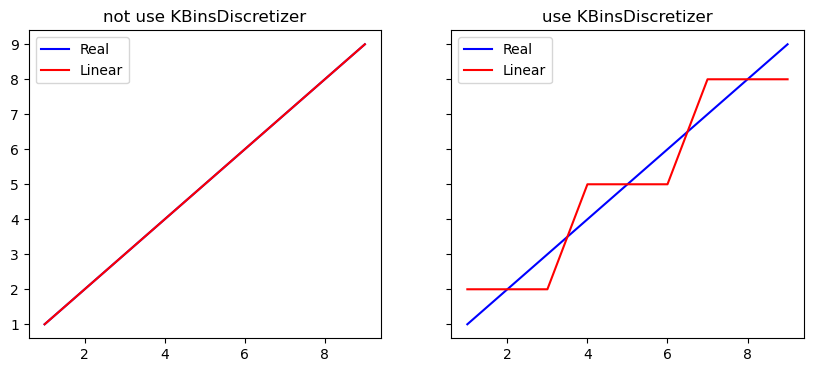

In [126]:
fig, (ax1, ax2) = plt.subplots(ncols=2
                               , sharey=True #让两张图共享y轴上的刻度
                               , figsize=(10, 4))
x_range = sorted(X_simple)
ax1.plot(x_range, x_range, c='b')
ax1.plot(x_range, sorted(y_simple_pred), c='r')
ax1.legend(['Real', 'Linear'])
ax1.set_title('not use KBinsDiscretizer')

x_range = sorted(X_simple)
ax2.plot(x_range, x_range, c='b')
ax2.plot(x_range, sorted(y_simple_pred2), c='r')
ax2.legend(['Real', 'Linear'])
ax2.set_title('use KBinsDiscretizer')

##### 非线性可分数据

(100,)
(100, 1)


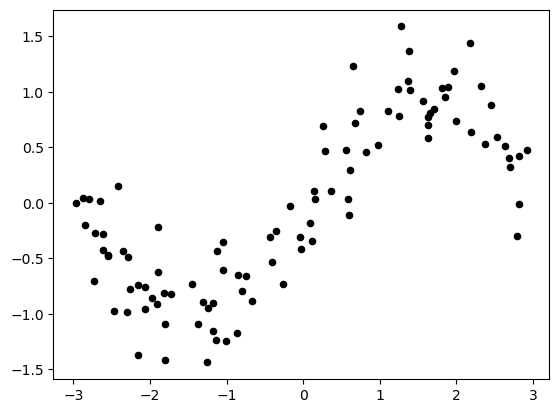

In [129]:
# 2. 创建需要拟合的数据集
rnd = np.random.RandomState(42) #设置随机数种子
X = rnd.uniform(-3, 3, size=100) #random.uniform，从输入的任意两个整数中取出size个随机数
#生成y的思路：先使用NumPy中的函数生成一个sin函数图像，然后再人为添加噪音
y = np.sin(X) + rnd.normal(size=len(X)) / 3 #random.normal，生成size个服从正态分布的随机数

#创建测试数据：一系列分布在横坐标上的点
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)


#使用散点图观察建立的数据集是什么样子
plt.scatter(X, y,marker='o',c='k',s=20)

#为后续建模做准备：sklearn只接受二维以上数组作为特征矩阵的输入
print(X.shape)
X = X.reshape(-1, 1)
print(X.shape)


In [130]:
# 使用原始数据训练模型
LinearR = LR()
LinearR = LinearR.fit(X, y)

TreeR = DecisionTreeRegressor(random_state=0)
TreeR = TreeR.fit(X, y)

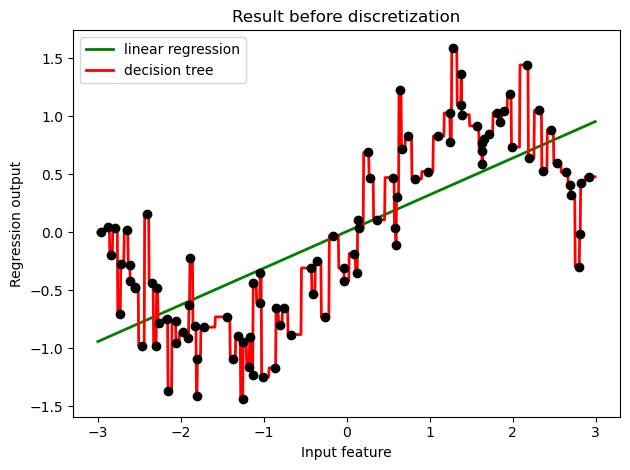

In [64]:
#3.2 显示原始训练模型效果
# 放置画布
fig, ax1 = plt.subplots(1)
#创建测试数据：一系列分布在横坐标上的点
line_X = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1) #1000个测试样本

#将测试数据带入predict接口，获得模型的拟合效果并进行绘制
ax1.plot(line_X, LinearR.predict(line_X), linewidth=2, color='green', label="linear regression")
ax1.plot(line_X, TreeR.predict(line_X), linewidth=2, color='red', label="decision tree")
#将原数据上的拟合绘制在图像上
ax1.plot(X[:, 0], y, 'o', c='k')
#其他图形选项
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")
plt.tight_layout()


分箱后建模

In [136]:
# 分箱前
LinearR = LR().fit(X, y)
TreeR = DecisionTreeRegressor(random_state=0).fit(X, y)

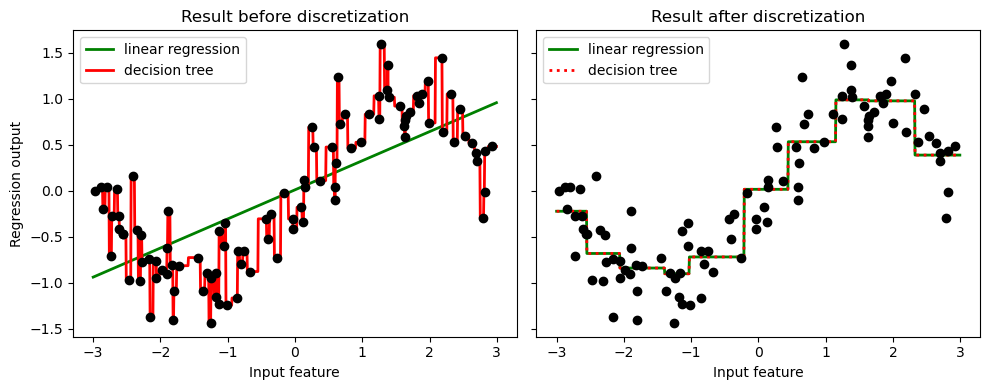

In [138]:

#将两张图像绘制在一起，布置画布
fig, (ax1, ax2) = plt.subplots(ncols=2
                               , sharey=True #让两张图共享y轴上的刻度
                               , figsize=(10, 4))
#在图1中布置在原始数据上建模的结果
ax1.plot(line, LinearR.predict(line), linewidth=2, color='green',
         label="linear regression")
ax1.plot(line, TreeR.predict(line), linewidth=2, color='red',
         label="decision tree")
ax1.plot(X[:, 0], y, 'o', c='k')
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")


# 分箱后
#准备数据
enc = KBinsDiscretizer(n_bins=10,encode="onehot")
X_binned = enc.fit_transform(X)
line_binned = enc.transform(line)
#使用分箱数据进行建模
LinearR_ = LR().fit(X_binned, y)
TreeR_ = DecisionTreeRegressor(random_state=0).fit(X_binned, y)
#进行预测，在图2中布置在分箱数据上进行预测的结果
ax2.plot(line #横坐标
         , LinearR_.predict(line_binned) #分箱后的特征矩阵的结果
         , linewidth=2
         , color='green'
         , linestyle='-'
         , label='linear regression')
ax2.plot(line, TreeR_.predict(line_binned), linewidth=2, color='red',
         linestyle=':', label='decision tree')

#将原始数据分布放置在图像上
ax2.plot(X[:, 0], y, 'o', c='k')
#其他绘图设定
ax2.legend(loc="best")
ax2.set_xlabel("Input feature")
ax2.set_title("Result after discretization")
plt.tight_layout()


   对于线性模型，分箱可以实现线性可分。对于决策树，分箱可以防止过拟合。

   在工业中，大量离散化变量与线性模型连用的实例很多，在深度学习出现之前，这种模式甚至一度统治一些工业中的
机器学习应用场景，可见效果优秀，应用广泛。对于现在的很多工业场景而言，大量离散化特征的情况可能已经不是
那么多了，不过大家依然需要对“分箱能够解决线性模型无法处理非线性数据的问题”有所了解。

##### 多项式回归
用房价数据测试，看是否能提升评分

In [160]:
from sklearn.preprocessing import PolynomialFeatures

housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target)

In [161]:
poly = PolynomialFeatures(degree=2).fit(X)
X_poly = pd.DataFrame(poly.transform(X))
X_poly

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,69.308955,...,103684.0,822.888889,12197.36,-39358.06,6.530864,96.804444,-312.365556,1434.8944,-4630.0724,14940.1729
1,1.0,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,68.913242,...,5764801.0,5065.730228,90901.86,-293450.22,4.451433,79.878612,-257.864868,1433.3796,-4627.2492,14937.7284
2,1.0,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,52.669855,...,246016.0,1389.920904,18773.60,-60631.04,7.852660,106.065537,-342.548249,1432.6225,-4626.7840,14942.6176
3,1.0,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,31.844578,...,311364.0,1421.753425,21120.30,-68215.50,6.492025,96.439726,-311.486301,1432.6225,-4627.1625,14945.0625
4,1.0,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,14.793254,...,319225.0,1232.528958,21385.25,-69071.25,4.758799,82.568533,-266.684363,1432.6225,-4627.1625,14945.0625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.0,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,2.434536,...,714025.0,2163.712121,33360.60,-102321.05,6.556703,101.092727,-310.063788,1558.6704,-4780.6332,14662.7881
20636,1.0,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,6.537226,...,126736.0,1111.719298,14058.44,-43150.76,9.751924,123.319649,-378.515439,1559.4601,-4786.5829,14691.8641
20637,1.0,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,2.890000,...,1014049.0,2341.914550,39706.01,-122068.54,5.408579,91.699792,-281.913487,1554.7249,-4779.7046,14694.2884
20638,1.0,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,3.486436,...,549081.0,1573.297994,29217.63,-89898.12,4.508017,83.718138,-257.587736,1554.7249,-4783.6476,14718.5424


In [163]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_poly,y,test_size=0.3,random_state=42)
Xtrain

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
7061,1.0,4.1312,35.0,5.882353,0.975490,1218.0,2.985294,33.93,-118.02,17.066813,...,1483524.0,3636.088235,41326.74,-143748.36,8.911981,101.291029,-352.324412,1151.2449,-4004.4186,13928.7204
14689,1.0,2.8631,20.0,4.401210,1.076613,999.0,2.014113,32.79,-117.09,8.197342,...,998001.0,2012.098790,32757.21,-116972.91,4.056651,66.042762,-235.832480,1075.1841,-3839.3811,13710.0681
17323,1.0,4.2026,24.0,5.617544,0.989474,731.0,2.564912,34.59,-120.14,17.661847,...,534361.0,1874.950877,25285.29,-87822.34,6.578775,88.720316,-308.148561,1196.4681,-4155.6426,14433.6196
10056,1.0,3.1094,14.0,5.869565,1.094203,302.0,2.188406,39.26,-121.00,9.668368,...,91204.0,660.898551,11856.52,-36542.00,4.789120,85.916812,-264.797101,1541.3476,-4750.4600,14641.0000
15750,1.0,3.3068,52.0,4.801205,1.066265,1526.0,2.298193,37.77,-122.45,10.934926,...,2328676.0,3507.042169,57637.02,-186858.70,5.281690,86.802741,-281.413705,1426.5729,-4624.9365,14994.0025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1.0,6.3700,35.0,6.129032,0.926267,658.0,3.032258,33.78,-117.96,40.576900,...,432964.0,1995.225806,22227.24,-77617.68,9.194589,102.429677,-357.685161,1141.0884,-3984.6888,13914.5616
11964,1.0,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,34.02,-117.43,9.302500,...,3073009.0,6844.118040,59637.06,-205854.79,15.243025,132.821960,-458.473920,1157.3604,-3994.9686,13789.8049
5390,1.0,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38,8.610703,...,3083536.0,5851.111954,59756.68,-207875.28,11.102679,113.390285,-394.450247,1158.0409,-4028.4714,14013.8244
860,1.0,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96,32.709249,...,3157729.0,5648.889088,66779.66,-216722.92,10.105347,119.462719,-387.697531,1412.2564,-4583.2568,14874.2416


In [164]:
lr =  LR().fit(Xtrain,Ytrain)

In [165]:
lr.coef_

array([[ 8.40993818e-08, -1.17657598e+01, -8.02629170e-01,
         7.41714912e+00, -3.70415469e+01, -3.12434154e-04,
         8.86884323e-01,  8.54961512e+00,  6.22321988e+00,
        -3.33830074e-02,  1.79444973e-03,  4.68581378e-02,
        -1.57572396e-01,  4.83632761e-05, -4.01089428e-03,
        -1.62888303e-01, -1.51627122e-01,  2.34558051e-04,
        -1.15772116e-03,  1.22824026e-02,  2.55864056e-06,
        -1.74849835e-03, -9.80940520e-03, -9.50801910e-03,
         1.22890612e-02, -1.20972599e-01, -5.37031556e-05,
         2.15110436e-02,  1.04692533e-01,  9.57738463e-02,
         2.98634870e-01,  4.68989736e-04, -9.16860585e-02,
        -5.31659377e-01, -4.77571246e-01,  1.47533638e-09,
         2.32267925e-05,  1.09430681e-05,  5.03831792e-06,
         5.18868264e-05,  2.03113283e-02,  1.45797305e-02,
         5.90753100e-02,  1.04575777e-01,  4.06438383e-02]])

In [166]:
Ypred = lr.predict(Xtest)
print(MSE(Ytest, Ypred))
print(r2_score(Ytest, Ypred))

0.4549723400347175
0.6533650001808258


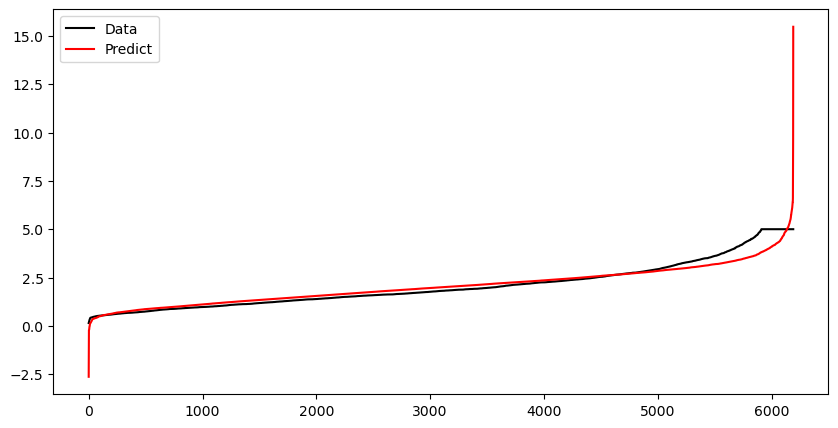

In [167]:
# 绘制预测房价的变化规律
plt.figure(figsize=(10,5))
y_test_list = Ytest.values.flatten()
y_pred_list = Ypred.flatten()
plt.plot(range(len(y_test_list)),sorted(y_test_list),c="black",label= "Data")
plt.plot(range(len(y_pred_list)),sorted(y_pred_list),c="red",label = "Predict")
plt.legend()

多项式回归的拟合程度更好